# 12.5 Lab: Unsupervised Learning

In [201]:
import warnings
warnings.filterwarnings('ignore')

In [202]:
#conda install -c districtdatalabs yellowbrick -y

In [203]:
import pandas as pd
import numpy as np
from numpy.linalg import svd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy

%matplotlib inline
import seaborn as sns
sns.set_theme()
sns.set_style("ticks")

## 12.5.1 Principal Components Analysis

In this lab, we perform PCA on the `USArrests` data set, which is part of the base `R` package.
The rows of the data set contain the 50 states, in alphabetical order.

In [204]:
USArrests = pd.read_csv('https://raw.githubusercontent.com/tvanzyl/Sharing_ISL_python/master/data/USArrests.csv', index_col=0)

In [205]:
USArrests.head()

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


The columns of the data set contain the four variables.

In [206]:
USArrests.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


We first briefly examine the data. We notice that the variables have vastly different means.

We see that there are on average three times as many rapes as murders, and more than eight times as many assaults as rapes. We can also examine the variances of the four variables.

Not surprisingly, the variables also have vastly different variances:
> the `UrbanPop` variable measures the percentage of the population in each state living in an urban area, which is not a comparable number to the number of rapes in each state per 100,000 individuals.

If we failed to scale the variables before performing PCA, then most of the principal components that we observed would be driven by the `Assault` variable, since it has by far the largest mean and variance.
Thus, it is important to standardize the variables to have mean zero and standard deviation one before performing PCA.

In [207]:
sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(USArrests), index=USArrests.index, columns=USArrests.columns)

By using the option `StandardScaler`, we scale the variables to have standard deviation one. 

We now perform principal components analysis using the `PCA()` function, which is one of several functions in `python` that perform PCA.

In [208]:
pca = PCA().fit(X)

# The loading vectors (i.e. these are the projection of the data onto the principal components)
pca_loadings = pd.DataFrame(pca.components_.T, index=USArrests.columns, columns=['V1', 'V2', 'V3', 'V4'])
pca_loadings

# X1 = pd.DataFrame(sc.inverse_transform(X), index=USArrests.index, columns=USArrests.columns)

,V1,V2,V3,V4
Murder,0.535899,0.418181,-0.341233,0.649228
Assault,0.583184,0.187986,-0.268148,-0.743407
UrbanPop,0.278191,-0.872806,-0.378016,0.133878
Rape,0.543432,-0.167319,0.817778,0.089024


Depends on the version of python/module, you may see a flipped loading vector in signs.  This is normal because the orientation of the principal components is not deterministic. 

The output from `PCA()` contains a number of useful quantities.

In [209]:
pca.mean_

array([-7.10542736e-17,  1.38777878e-16, -4.39648318e-16,  8.59312621e-16])

The `mean_` components correspond to the mean of the variables that were used for scaling prior to implementing PCA.

In [210]:
pca.components_

array([[ 0.53589947,  0.58318363,  0.27819087,  0.54343209],
       [ 0.41818087,  0.1879856 , -0.87280619, -0.16731864],
       [-0.34123273, -0.26814843, -0.37801579,  0.81777791],
       [ 0.6492278 , -0.74340748,  0.13387773,  0.08902432]])

The `components_` matrix provides the principal component loadings; each column of `components_` contains the corresponding principal component loading vector. ( *Sometimes called the rotation matrix, because when we matrix-multiply the $\bf X$  matrix by `components_`, it gives us the coordinates of the   data in the rotated coordinate system. These coordinates are the  principal component scores.* )


We can plot the first two principal components as follows:

Notice that this figure is a mirror image of Figure 12.1. Recall that the principal components are only unique up to a sign change, so we can reproduce Figure 12.1 by making a few small changes:

In [211]:
df_plot = pd.DataFrame(pca.transform(X), columns=['PC1', 'PC2', 'PC3', 'PC4'], index=X.index)

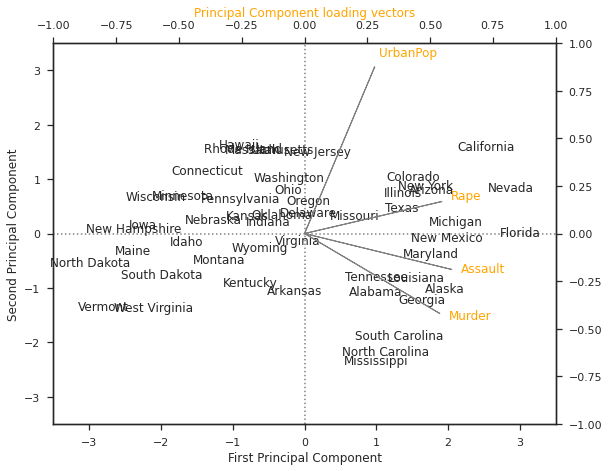

In [212]:
fig , ax1 = plt.subplots(figsize=(9,7))

ax1.set_xlim(-3.5,3.5)
ax1.set_ylim(-3.5,3.5)

# Plot Principal Components 1 and 2
for i in df_plot.index:
    ax1.annotate(i, (df_plot.PC1.loc[i], -df_plot.PC2.loc[i]), ha='center')

# Plot reference lines
ax1.hlines(0,-3.5,3.5, linestyles='dotted', colors='grey')
ax1.vlines(0,-3.5,3.5, linestyles='dotted', colors='grey')

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
    
# Plot Principal Component loading vectors, using a second y-axis.
ax2 = ax1.twinx().twiny() 

ax2.set_ylim(-1,1)
ax2.set_xlim(-1,1)
ax2.tick_params(axis='y', colors='orange')
ax2.set_xlabel('Principal Component loading vectors', color='orange')

# Plot labels for vectors. Variable 'a' is a small offset parameter to separate arrow tip and text.
a = 1.07  
for i in pca_loadings[['V1', 'V2']].index:
    ax2.annotate(i, (pca_loadings.V1.loc[i]*a, -pca_loadings.V2.loc[i]*a), color='orange')

# Plot vectors
ax2.arrow(0,0,pca_loadings.V1[0],-pca_loadings.V2[0],color='grey')
ax2.arrow(0,0,pca_loadings.V1[1],-pca_loadings.V2[1],color='grey')
ax2.arrow(0,0,pca_loadings.V1[2],-pca_loadings.V2[2],color='grey')
ax2.arrow(0,0,pca_loadings.V1[3],-pca_loadings.V2[3],color='grey');

We see that there are four distinct principal components. This is to be expected because there are in general $\min(n-1,p)$ informative principal components in a data set with $n$ observations and $p$ variables.

Using the `transform()` function, we do not need to explicitly multiply the data by the principal component loading vectors  in order to obtain the principal component score vectors. Rather the $50 \times 4$ dataframe `df_plot` has as its columns the principal component score vectors. That is, the $k$th column is the $k$th principal component score vector.

The `PCA()` class also outputs the standard deviation of each principal component. For instance, on the `USArrests` data set, we can access these standard deviations as follows:

In [213]:
print(np.sqrt(pca.explained_variance_))

[1.5908673  1.00496987 0.6031915  0.4206774 ]


The variance explained by each principal component is obtained by squaring these:

In [214]:
print(pca.explained_variance_)

[2.53085875 1.00996444 0.36383998 0.17696948]


To compute the proportion of variance explained by each principal component, we simply divide the variance explained by each principal component by the total variance explained by all four principal components:

In [215]:
print(pca.explained_variance_ratio_)

[0.62006039 0.24744129 0.0891408  0.04335752]


in a previous chapter, we talk about PCR. In that case, we could use the downstream task's (i.e. regression RMSE) performance to select the hyperparameters (i.e. # number of PCs).

Here let us use the portion of explained variance to select the number of PCs. Those info is available in the pca object.

We see that the first principal component explains $62.0\,\%$ of the variance in the data, the next principal component explains $24.7\,\%$ of the variance, and so forth.
 We can plot the PVE explained by each component, as well as the cumulative PVE, as follows:

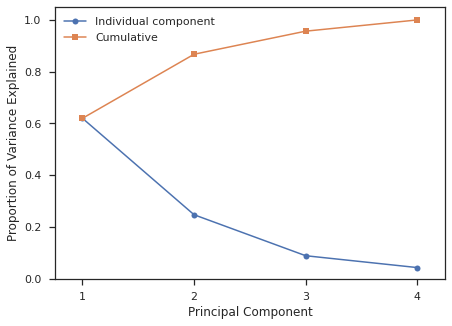

In [216]:
plt.figure(figsize=(7,5))

plt.plot([1,2,3,4], pca.explained_variance_ratio_, '-o', label='Individual component')
plt.plot([1,2,3,4], np.cumsum(pca.explained_variance_ratio_), '-s', label='Cumulative')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4])
plt.legend(loc=2)
plt.show()

In this case, if we want to preserve 80% of variance of the data, we need to select 2 PCs. In this case, if we want to preserve 80% of variance of the data, we need to select 2 PCs.

The result is shown in Figure 12.3. Note that the function `cumsum()` computes the cumulative sum of the elements of  a numeric vector. For instance:

In [217]:
np.cumsum(pca.explained_variance_ratio_)

array([0.62006039, 0.86750168, 0.95664248, 1.        ])

## 12.5.2 Matrix Completion

We now re-create the analysis carried out on the **USArrests** data in Section 12.3. We turn the data frame into a
matrix, after centering and scaling each column to have mean zero and variance one.

Run sigular value decomposition on the data (SVD).

In [218]:
u, s, vh = svd(X, full_matrices=False)
u.shape, s.shape, vh.shape

((50, 4), (4,), (4, 4))

The `svd()` function returns three components, `u`, `s`, and `v`. The matrix `vh` is equivalent to the
loading matrix from principal components (up to an unimportant sign flip).

In [219]:
print(vh)
print ('-------')
print(pca.components_)

[[-0.53589947 -0.58318363 -0.27819087 -0.54343209]
 [ 0.41818087  0.1879856  -0.87280619 -0.16731864]
 [-0.34123273 -0.26814843 -0.37801579  0.81777791]
 [ 0.6492278  -0.74340748  0.13387773  0.08902432]]
-------
[[ 0.53589947  0.58318363  0.27819087  0.54343209]
 [ 0.41818087  0.1879856  -0.87280619 -0.16731864]
 [-0.34123273 -0.26814843 -0.37801579  0.81777791]
 [ 0.6492278  -0.74340748  0.13387773  0.08902432]]


We see that the first principal component explains $62\%$ of the variance. 

We saw in Section 12.2.2 that solving the optimization problem (12.6)  on a centered data matrix $\bf X$ is equivalent to computing the first $M$ principal components of the data. The  (SVD)  is a general algorithm for solving (12.6).

The matrix `u` is equivalent to the matrix of *standardized* scores, and the standard deviations are in the vector `s`. We can recover the score vectors using the output of `svd()`.

They are identical to the score vectors output by `PCA()`.

In [220]:
# reconstruction based on full SVD
np.allclose(X, np.dot(u * s, vh))

True

this `vh` will be the principal components similar to pca.components_ (up to an unimportant sign flip). The matrix `u` is equivalent to the matrix of standardized scores, and the standard deviations are in the vector `s`.

While it would be possible to carry out this lab using the `PCA()` function,
here we use the `svd()` function in order to illustrate its use.

In [221]:
# reconstruction based on reduced SVD
num_components = 3
recovered = pd.DataFrame(np.dot(u[:, :num_components] * s[:num_components,], vh[:num_components,:]))

Change the num_components from 1 to 4 and see how the reconstruction error changes.

In [222]:
print(recovered.head(n=2))
print(X.head(n=2))

          0         1         2         3
0  1.153726  0.906957 -0.547116 -0.017363
1  0.797759  0.792013 -1.165350  2.548469
           Murder   Assault  UrbanPop      Rape
Alabama  1.255179  0.790787 -0.526195 -0.003451
Alaska   0.513019  1.118060 -1.224067  2.509424


Write some code to implement Algorithm 12.1.

In [223]:
#TODO: Exercise

## 12.5.3 Clustering

### K-means clustering 

The class `KMeans()` performs $K$-means clustering in `python`.  We begin with a simple simulated example in which there truly are two clusters in the data: 
> the first 25 observations have a mean shift relative to the next 25 observations.

In [224]:
# generate data
np.random.seed(21)
X = np.random.standard_normal((50,2))
X[:25,0] = X[:25,0]+3
X[:25,1] = X[:25,1]-4

We now perform $K$-means clustering with $K=2$.

In [225]:
n_clusters = 2
km1 = KMeans(n_clusters=n_clusters)
km1.fit(X)

KMeans(n_clusters=2)

The cluster assignments of the 50 observations are contained in  `km1.labels_`.

In [226]:
print(km1.labels_)
print(dir(km1)) # we can use dir to see other saved attributes

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_algorithm', '_check_feature_names', '_check_mkl_vcomp', '_check_n_features', '_check_params', '_check_test_data', '_estimator_type', '_get_param_names', '_get_tags', '_init_centroids', '_more_tags', '_n_features_out', '_n_init', '_n_threads', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_tol', '_transform', '_validate_center_shape', '_validate_data', '_warn_mkl_vcomp', 'algorithm', 'cluster_centers_', 'copy_x', 'fit', 'fit_predict', 'fit_transform', 'ge

The $K$-means clustering perfectly separated the observations into two clusters even though we did not supply any group information to `kmeans()`. We can plot the data, with each observation
colored according to its cluster assignment.

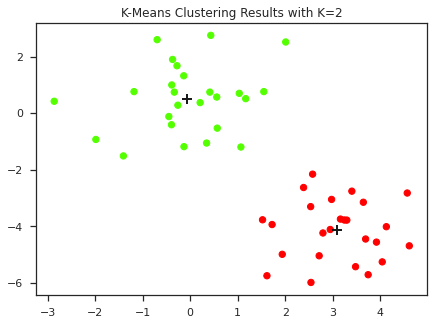

In [227]:
fig, ax1 = plt.subplots(1,1, figsize=(7,5))

ax1.scatter(X[:,0], X[:,1], s=40, c=km1.labels_, cmap=plt.cm.prism) 
ax1.set_title('K-Means Clustering Results with K=2')
ax1.scatter(km1.cluster_centers_[:,0], km1.cluster_centers_[:,1], marker='+', s=100, c='k', linewidth=2)

plt.show()

Here the observations can be easily plotted because they are two-dimensional. If there were more than two
variables then we could instead perform PCA and plot the first two principal components score vectors.

In this example, we knew that there really were two clusters because we generated the data. However, for real data, in general we do not
know the true number of clusters. We could instead have performed $K$-means clustering on this example with $K=3$.

In [228]:
n_clusters = 3
km2 = KMeans(n_clusters=n_clusters)
km2.fit(X)

KMeans(n_clusters=3)

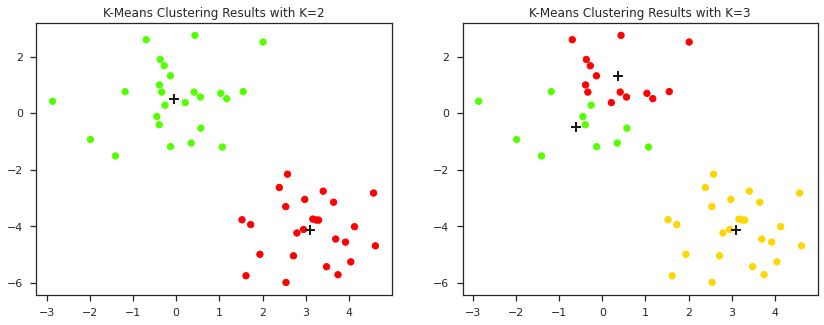

In [229]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

ax1.scatter(X[:,0], X[:,1], s=40, c=km1.labels_, cmap=plt.cm.prism) 
ax1.set_title('K-Means Clustering Results with K=2')
ax1.scatter(km1.cluster_centers_[:,0], km1.cluster_centers_[:,1], marker='+', s=100, c='k', linewidth=2)

ax2.scatter(X[:,0], X[:,1], s=40, c=km2.labels_, cmap=plt.cm.prism) 
ax2.set_title('K-Means Clustering Results with K=3')
ax2.scatter(km2.cluster_centers_[:,0], km2.cluster_centers_[:,1], marker='+', s=100, c='k', linewidth=2)
plt.show()

When $K=3$, $K$-means clustering  splits up the two clusters.

To run the `KMeans()` function in `python` with multiple initial cluster assignments, we use the `n_init` argument. If a value of `n_init` is greater than one is used, then $K$-means clustering will be performed using multiple random assignments in Step~1 of Algorithm 12.2, and the `KMeans()` class will report only the best results. Here we can compare using `n_init = 1` to `n_init = 10`. `n_init = 10` is the default value.

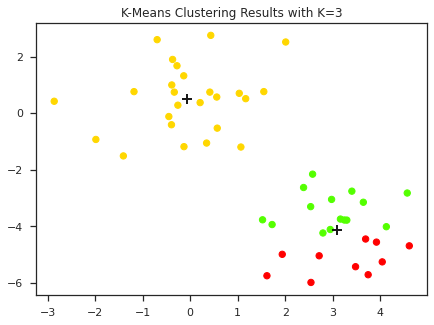

In [230]:
n_clusters = 3
kmi = KMeans(n_clusters=n_clusters, n_init=1)
kmi.fit(X)

fig, ax1 = plt.subplots(1,1, figsize=(7,5))

ax1.scatter(X[:,0], X[:,1], s=40, c=kmi.labels_, cmap=plt.cm.prism) 
ax1.set_title('K-Means Clustering Results with K=3')
ax1.scatter(km1.cluster_centers_[:,0], km1.cluster_centers_[:,1], marker='+', s=100, c='k', linewidth=2)

plt.show()

We *strongly* recommend always running $K$-means clustering with a large value of `n_init`, such as 20 or 50, since otherwise an undesirable local optimum may be obtained.

When performing $K$-means clustering, in addition to using multiple initial cluster assignments, it is
also  important to set a random seed `random_state`. This way, the initial cluster assignments in Step~1 can be replicated, and the $K$-means output will be fully reproducible.

### Hierarchical Clustering

The `hierarchy` package implements  hierarchical clustering in `python`. In the following example we use the data from the previous lab to  plot the hierarchical clustering dendrogram using complete, single, and average linkage clustering, with  Euclidean distance as the dissimilarity measure.

We begin by clustering observations using complete linkage. The `dist()` function is used to compute the $50 \times 50$ inter-observation Euclidean distance matrix. We could just as easily perform hierarchical clustering with average or single linkage instead:

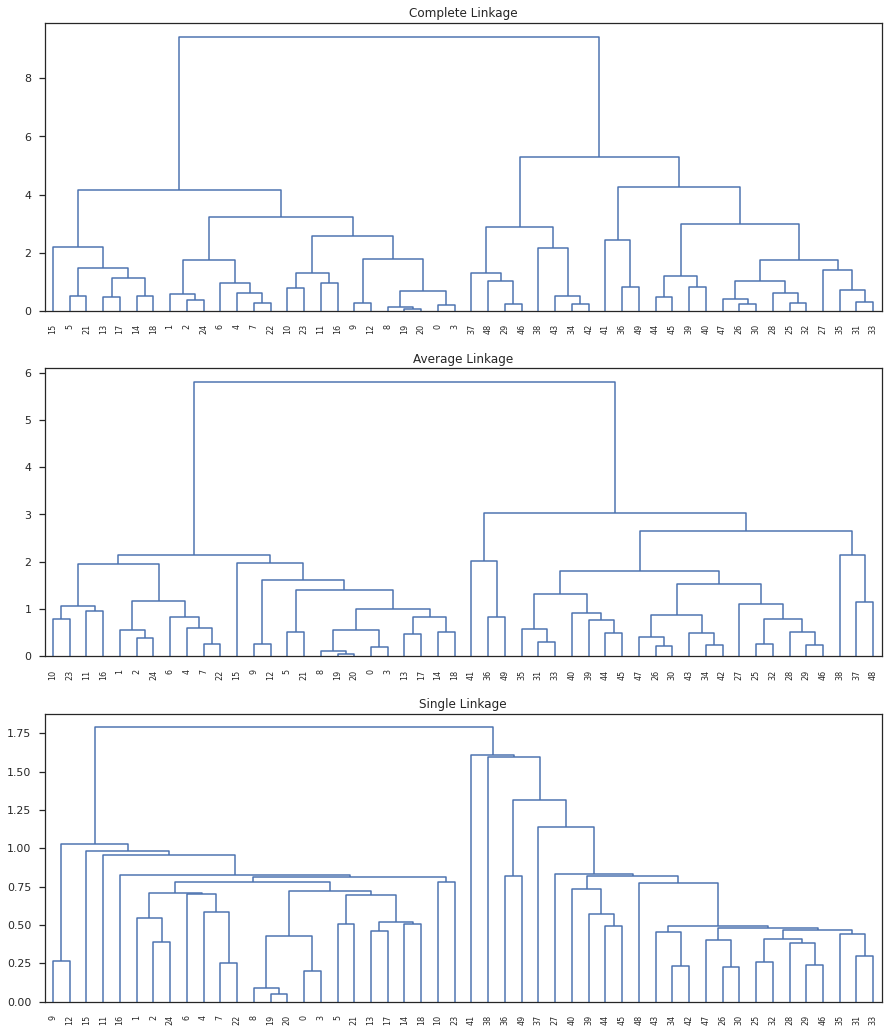

In [231]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,18))

for linkage, cluster, ax in zip([hierarchy.complete(X), hierarchy.average(X), hierarchy.single(X)], ['c1','c2','c3'],
                                [ax1,ax2,ax3]):
    cluster = hierarchy.dendrogram(linkage, ax=ax, color_threshold=0)

ax1.set_title('Complete Linkage')
ax2.set_title('Average Linkage')
ax3.set_title('Single Linkage')
plt.show()

We can now plot the dendrograms obtained using the usual `dendrogram()` function. The numbers at the bottom of the plot identify each observation.

To determine the cluster labels for each observation associated with a given cut of the dendrogram, we can use the `cutree()` function:

In [232]:
hierarchy.cut_tree(linkage, n_clusters=4).T

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1,
        1, 1, 1, 1, 1, 1]])

The second argument to `cut_ree()` is the number of clusters we wish to obtain.
For this data, complete and average linkage generally separate the observations into their correct groups. However, single linkage identifies one point as belonging to its own cluster. A more sensible answer is obtained when four clusters are selected, although there are still two singletons.

## 12.5.4 NCI60 Data Example

Unsupervised techniques are often used in the analysis of genomic data. In particular, PCA and hierarchical clustering are popular tools.
 We  illustrate these techniques on the `NCI` cancer cell line microarray data, which consists of $6{,}830$ gene expression measurements on $64$ cancer cell lines.

In [233]:
# I was not able to make the json work, so I went back to R and saved the data and label separately.
X = pd.read_csv('https://raw.githubusercontent.com/tvanzyl/Sharing_ISL_python/master/data/NCI60_data.csv')
y = pd.read_csv('https://raw.githubusercontent.com/tvanzyl/Sharing_ISL_python/master/data/NCI60_labs.csv')

In [234]:
y

,x
0,CNS
1,CNS
2,CNS
3,RENAL
4,BREAST
...,...
59,MELANOMA
60,MELANOMA
61,MELANOMA
62,MELANOMA


Each cell line is labeled with a cancer type, given in `y`. We do not make use of the cancer types in performing PCA and clustering, as these are unsupervised techniques. But after performing PCA and clustering, we will check to see the extent to which these cancer types agree with the results of these unsupervised techniques.

The data has $64$ rows and $6{,}830$ columns.

In [235]:
X.shape

(64, 6830)

We begin by examining the cancer types for the cell lines.

### PCA on the NCI60 Data

We first perform PCA on the data after scaling the variables (genes) to have standard deviation one, although one could reasonably argue that it is better not to scale the genes.

In [236]:
pca2 = PCA()
X_standardized = StandardScaler().fit_transform(X)
df2_plot = pd.DataFrame(pca2.fit_transform(X_standardized))

We now  plot the first few principal component score vectors, in order to visualize the data. The observations (cell lines) corresponding to a given cancer type will be plotted in the same color, so that we can see to what extent the observations within a cancer type are similar to each other. We first create a simple function that assigns a distinct color to each element of a numeric vector.
The function will be used to assign a  color to each of the $64$ cell lines, based on the cancer type to which it corresponds.

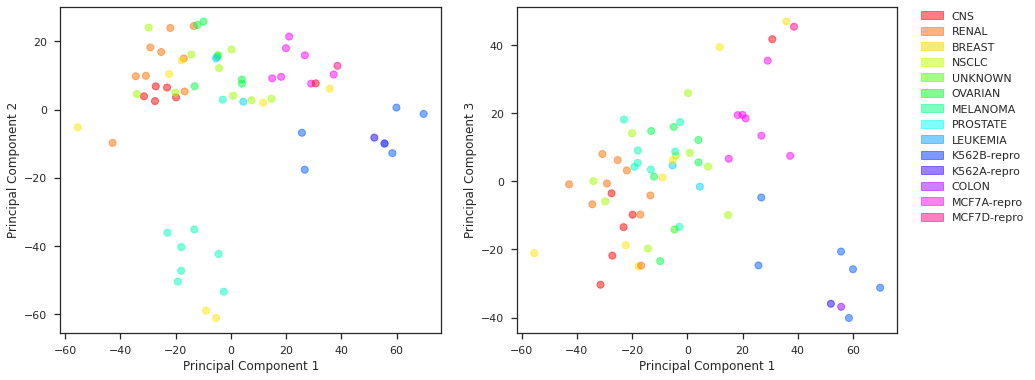

In [237]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))

color_idx = pd.factorize(y.iloc[:, 0])[0]
cmap = plt.cm.hsv

# left plot
ax1.scatter(df2_plot.iloc[:,0], -df2_plot.iloc[:,1], c=color_idx, cmap=cmap, alpha=0.5, s=50)
ax1.set_ylabel('Principal Component 2')

# right plot
ax2.scatter(df2_plot.iloc[:,0], df2_plot.iloc[:,2], c=color_idx, cmap=cmap, alpha=0.5, s=50)
ax2.set_ylabel('Principal Component 3')

# custom legend for the classes (y) since we do not create scatter plots per class (which could have their own labels).
handles = []
labels = pd.factorize(y.iloc[:, 0].unique())
norm = mpl.colors.Normalize(vmin=0.0, vmax=14.0)

for i, v in zip(labels[0], labels[1]):
    handles.append(mpl.patches.Patch(color=cmap(norm(i)), label=v, alpha=0.5))

ax2.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# xlabel for both plots
for ax in fig.axes:
    ax.set_xlabel('Principal Component 1')   

The resulting  plots are shown in Figure 12.17. On the whole, cell lines corresponding to a single cancer type do tend to have similar values on the first few
principal component score vectors. This indicates that cell lines from the same cancer type tend to have pretty similar gene expression levels.

On the whole, observations belonging to a single cancer type tend to lie near each other in this low-dimensional space. It would not have been possible to visualize the data without using a dimension reduction method such as PCA, since based on the full data set there are  $6{,}830 \choose 2$ possible scatterplots, none of which would have
been particularly informative.}

We can obtain a summary of the proportion of variance explained (PVE) of the first few principal components using the `explained_variance_ratio_` method for a `PCA` object (we have truncated the printout):

In [238]:
pd.DataFrame([df2_plot.iloc[:,:5].std(axis=0, ddof=0).array,
              pca2.explained_variance_ratio_[:5],
              np.cumsum(pca2.explained_variance_ratio_[:5])],
             index=['Standard Deviation', 'Proportion of Variance', 'Cumulative Proportion'],
             columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

,PC1,PC2,PC3,PC4,PC5
Standard Deviation,27.853469,21.481355,19.820465,17.032556,15.971807
Proportion of Variance,0.113589,0.067562,0.057518,0.042476,0.037350
Cumulative Proportion,0.113589,0.181151,0.238670,0.281145,0.318495


Using the `plot()` function, we can also plot the variance explained by the first few principal components.

Note that the height of each bar in the bar plot is given by he variance the corresponding element of `df2_plot`.
However, it is more informative to plot the PVE of each principal component (i.e. a scree plot) and the cumulative PVE of each principal component. This can be done with just a little work.

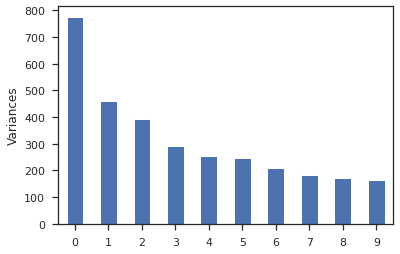

In [239]:
df2_plot.iloc[:,:10].var(axis=0, ddof=0).plot(kind='bar', rot=0)
plt.ylabel('Variances')
plt.show()

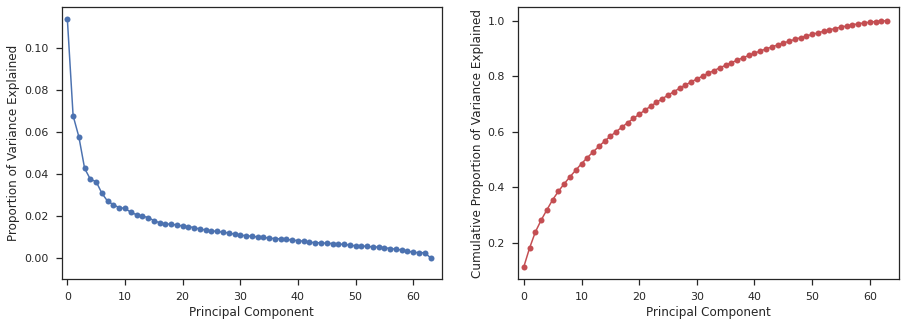

In [240]:
fig , (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

# left plot
ax1.plot(pca2.explained_variance_ratio_, '-o')
ax1.set_ylabel('Proportion of Variance Explained')
ax1.set_ylim(ymin=-0.01)

# right plot
ax2.plot(np.cumsum(pca2.explained_variance_ratio_), '-ro')
ax2.set_ylabel('Cumulative Proportion of Variance Explained')
ax2.set_ylim(ymax=1.05)

for ax in fig.axes:
    ax.set_xlabel('Principal Component')
    ax.set_xlim(-1,65) 

We see that together, the first seven principal components explain around $40\,\%$ of the variance in the data. This is not a huge amount of the variance. However, looking at the scree plot, we see that while each of the first seven principal components explain a substantial amount of  variance, there is a marked decrease in the variance explained by further principal components. That is, there is an *elbow*   in the plot after approximately the seventh principal component. 

This suggests that there may be little benefit to examining more than seven or so principal components (though even examining seven principal components may be difficult).

### Clustering the Observations of the NCI60 Data

We now proceed to hierarchically cluster the cell lines in the `NCI` data, with the goal of finding out whether or not the observations cluster into distinct types of cancer. To begin, we standardize the variables to have mean
 zero and standard deviation one. As mentioned earlier, this step is optional and should be performed only if we want each gene to be on the same *scale*.

In [241]:
sc = StandardScaler()
X_standardized = pd.DataFrame(sc.fit_transform(X), index=y.iloc[:, 0], columns=X.columns)

We now perform hierarchical clustering of the observations using complete, single, and average linkage. Euclidean distance is used as the dissimilarity measure.

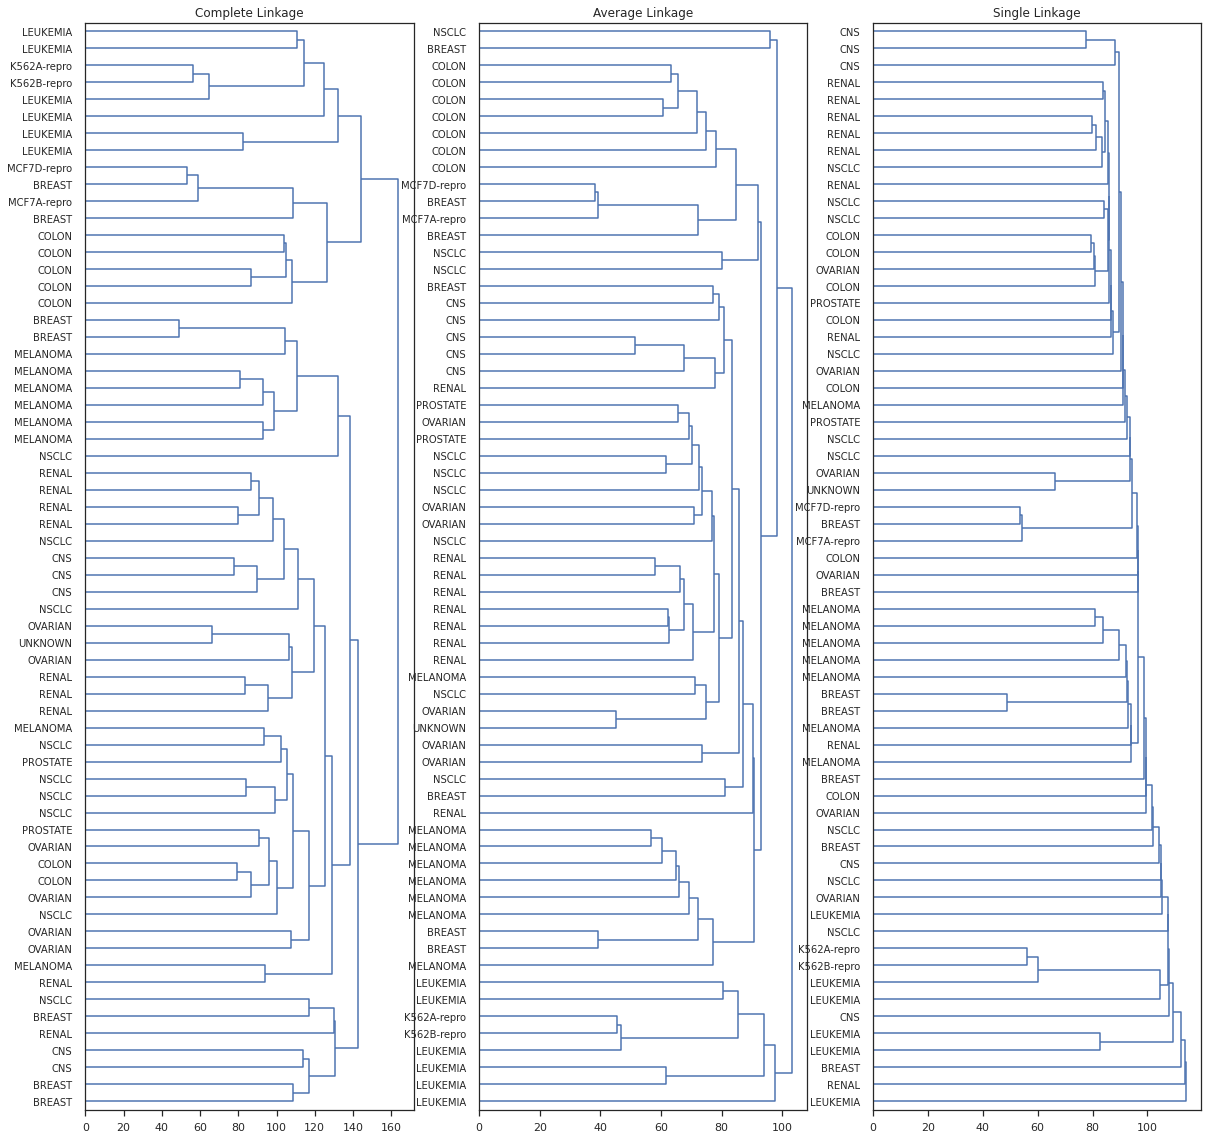

In [242]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,20))

for linkage, cluster, ax in zip([hierarchy.complete(X_standardized), hierarchy.average(X), hierarchy.single(X_standardized)],
                                ['c1','c2','c3'],
                                [ax1,ax2,ax3]):
    cluster = hierarchy.dendrogram(linkage, labels=X_standardized.index, orientation='right', color_threshold=0, leaf_font_size=10, ax=ax)

ax1.set_title('Complete Linkage')
ax2.set_title('Average Linkage')
ax3.set_title('Single Linkage')
plt.show()

The results are shown in Figure 12.19. We see that the choice of linkage certainly  does affect the results obtained. Typically, single linkage will tend to yield *trailing* clusters: very large clusters onto which individual observations attach  one-by-one. On the other hand, complete and average linkage tend to yield more balanced, attractive clusters. For this reason, complete and average linkage are generally preferred to single linkage.Clearly cell lines within a single cancer type do tend to cluster together, although the clustering is not perfect. We will use complete linkage hierarchical clustering for the analysis that follows.

We can cut the dendrogram at the height that will yield a particular number of clusters, say four. There are some clear patterns. All the leukemia cell lines fall in cluster $3$, while the breast cancer cell lines are spread out over three different clusters.  We can plot the cut on the dendrogram that produces these four clusters:

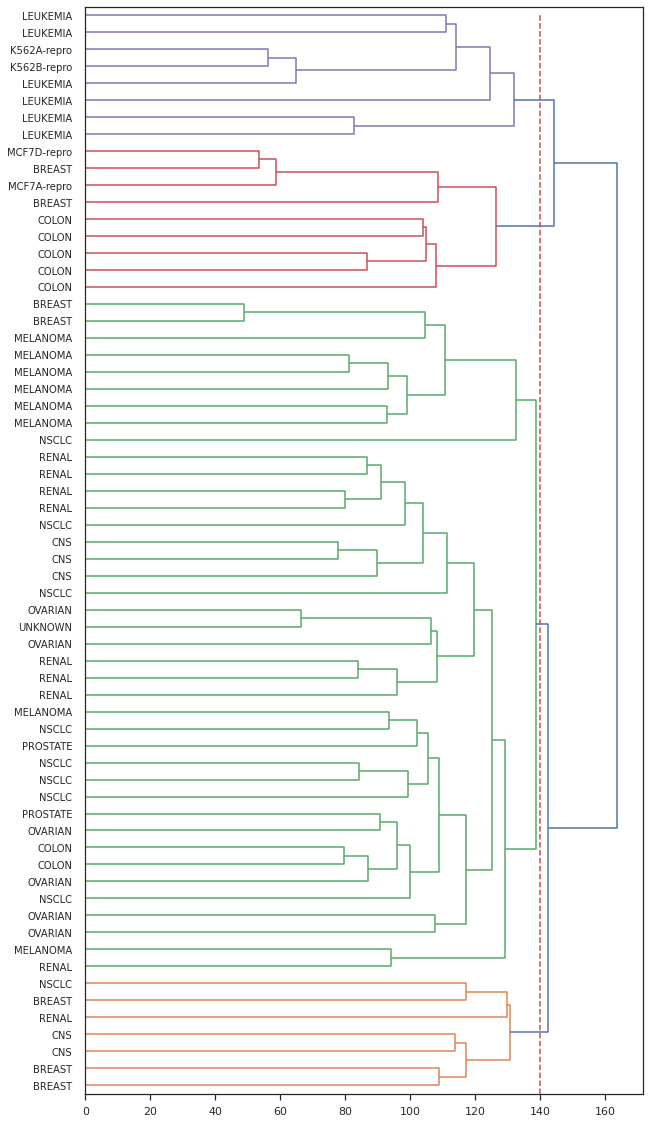

In [243]:
plt.figure(figsize=(10,20))
cut4 = hierarchy.dendrogram(hierarchy.complete(X_standardized),
                            labels=X_standardized.index, orientation='right', color_threshold=140, leaf_font_size=10)
plt.vlines(140,0,plt.gca().yaxis.get_data_interval()[1], colors='r', linestyles='dashed')
plt.show()

The `vlines()` function draws a straight line on top of any existing plot in `python`. The argument `h = 140` plots a horizontal line at height $140$ on the dendrogram; this is the height that results in four distinct clusters. It is easy to verify that the resulting clusters are the same as the ones we obtained using `cut_tree(..., 4)`.

Printing the output gives a useful brief summary of the object:

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [10.0, 10.0, 30.0, 30.0]],
 'dcoord': [[0.0, 111.51306850739942, 111.51306850739942, 0.0],
  [0.0, 118.25973071690086, 118.25973071690086, 0.0],
  [111.51306850739942,
   138.15044875568614,
   138.15044875568614,
   118.25973071690086]],
 'ivl': ['(11)', '(8)', '(3)', '(42)'],
 'leaves': [117, 120, 118, 123],
 'color_list': ['C0', 'C0', 'C0'],
 'leaves_color_list': ['C0', 'C0', 'C0', 'C0']}

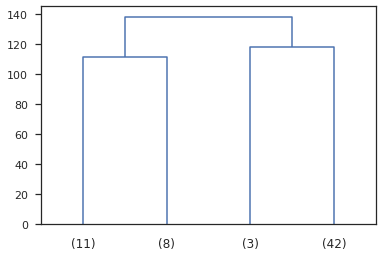

In [244]:
cut4b = hierarchy.dendrogram(hierarchy.complete(X), truncate_mode='lastp', p=4, show_leaf_counts=True)
cut4b

### Kmeans

We claimed earlier in Section 12.4.2 that $K$-means clustering and hierarchical clustering with the dendrogram cut to obtain the same number of clusters can yield very different results.
How do these `NCI` hierarchical clustering results compare to what we  get if we perform $K$-means clustering with $K=4$?

In [245]:
np.random.seed(21)
km4 = KMeans(n_clusters=4, n_init=50)
km4.fit(X_standardized)

KMeans(n_clusters=4, n_init=50)

In [246]:
km4.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3],
      dtype=int32)

In [247]:
hierarchy.cut_tree(hierarchy.complete(X), 4)[:,0]

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

We see that the four clusters obtained using hierarchical clustering and $K$-means clustering  are somewhat different. Cluster~$4$ in $K$-means clustering is identical to cluster~$3$
in hierarchical clustering. However, the other clusters differ: for instance, cluster~$2$ in $K$-means clustering contains a portion of the observations assigned to
cluster 1 by hierarchical clustering, as well as all of the observations assigned to cluster~$2$ by hierarchical clustering.

Rather than performing hierarchical clustering on the entire data matrix, we can simply perform hierarchical clustering on the first few principal component score vectors,
as follows:

### Combine with PCA

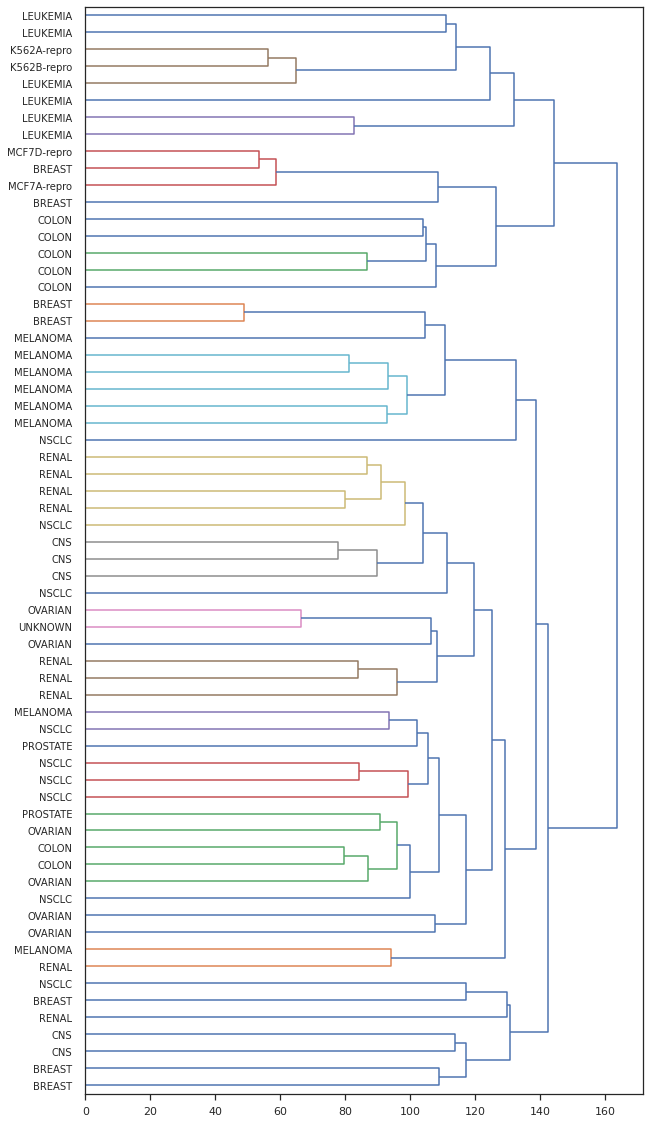

In [248]:
plt.figure(figsize=(10,20))
pca_cluster = hierarchy.dendrogram(hierarchy.complete(X_standardized), labels=X_standardized.index,
orientation='right', color_threshold=100, leaf_font_size=10)

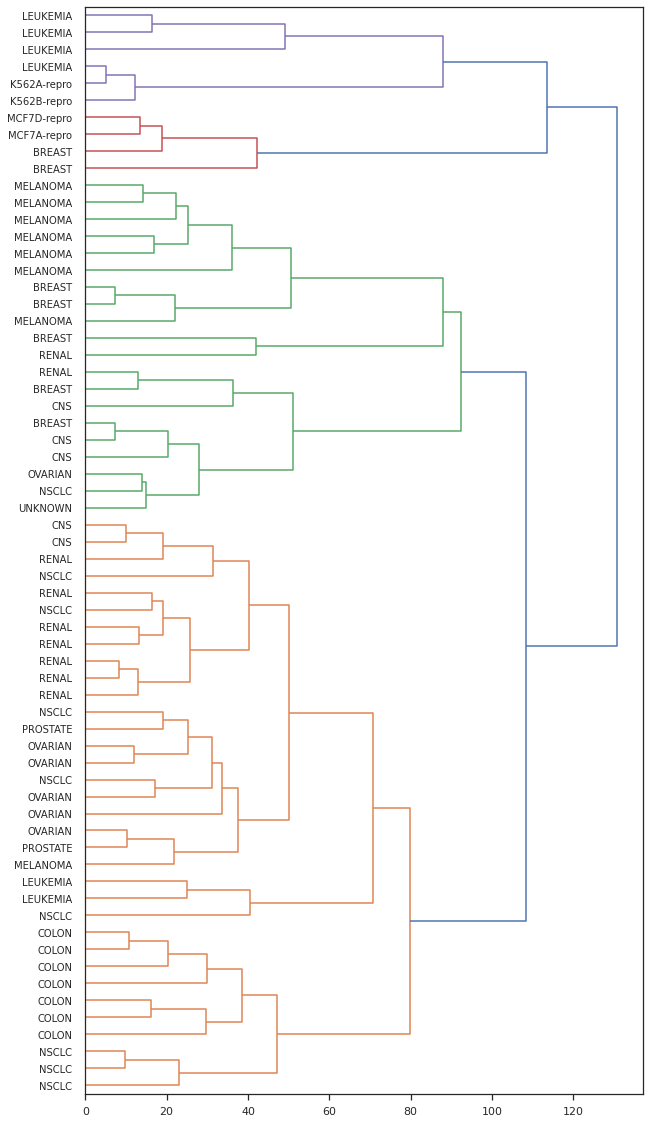

In [249]:
# Hierarchy based on Principal Components 1 to 5
plt.figure(figsize=(10,20))
pca_cluster = hierarchy.dendrogram(hierarchy.complete(df2_plot.iloc[:,:5]), labels=X_standardized.index,
orientation='right', color_threshold=100, leaf_font_size=10)

 Not surprisingly, these results are different from the ones that we
 obtained when we performed hierarchical clustering on the full data
 set. Sometimes performing clustering on the first few principal
 component score vectors can give better results than performing
 clustering on the full data.  In this situation, we might view the principal
component step as one of denoising the data.
We could also perform $K$-means
 clustering on the first few principal component score vectors rather
 than the full data set.







In [250]:
# End of Chapter 12